## Gamma ray bursts

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [100]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as clr
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.mixture import GaussianMixture
import emcee
import requests
import re
import corner

plt.rcParams["figure.figsize"] = (7, 7)

In [101]:
#Define relevant functions

def ComputeKDE(data, x_grid):
    cv = GridSearchCV(KernelDensity(kernel="gaussian"), {"bandwidth": np.arange(0.1, 0.5, 0.05)})
    cv.fit(data)
    b = cv.best_params_["bandwidth"]
    print("Best KDE bandwidth = " + str(b))
    
    kd = KernelDensity(kernel="gaussian", bandwidth=b)
    kd.fit(data)
    kde_pdf = np.exp(kd.score_samples(np.log10(x_grid[:, np.newaxis])))

    return kde_pdf


def ComputeKMeans(data, n_c):
    km = KMeans(n_init="auto", n_clusters=n_c)
    km.fit(data)
    centers = 10**km.cluster_centers_.flatten()
    labels = km.labels_

    if centers[0] > centers[1]:
        centers = centers[::-1]
        labels = np.array(~np.array(labels, dtype=bool), dtype=int)
        
    edge = 10**max(data[labels == 0])  
    
    return centers, edge


def ComputeMeanShift(data, bandwidth):
    ms = MeanShift(bandwidth=bandwidth, n_jobs=-1)
    ms.fit(data)
    centers = 10**ms.cluster_centers_.flatten()
    labels = ms.labels_

    for i in range(0, len(centers)):
        for j in range(i + 1, len(centers)):
            if centers[i] > centers[j]:
                temp1 = centers[i].copy()
                temp2 = centers[j].copy()
    
                i_idx = np.where(labels == np.where(centers == centers[i])[0])[0]
                j_idx = np.where(labels == np.where(centers == centers[j])[0])[0]

                centers[i] = temp2
                centers[j] = temp1
                
                labels[i_idx] = np.unique(np.where(centers == centers[j])[0])
                labels[j_idx] = np.unique(np.where(centers == centers[i])[0])

    edges = []

    for i in range(0, len(np.unique(np.argsort(centers))) - 1):    
        edges.append(10**max(data[labels == i]))  

    return centers, edges


def ComputeGMM(data, x_grid, n_g):
    gmm = GaussianMixture(n_components=n_g)
    gmm.fit(data)

    gmm_pdf = np.exp(gmm.score_samples(np.log10(x_grid[:, np.newaxis])))
    resp = gmm.predict_proba(data)
    means = 10**gmm.means_

    return gmm_pdf, resp, means
    

#Use KMeans, Meanshift and GMM to find clusters in the data

def ComputeClusters(dat, x_grid, do_KM=True, do_MS=True, do_GMM=True, ms_b=0.3):
    dat = dat[:, np.newaxis]

    fig, ax = plt.subplots()
    
    #KDE
    kde_pdf = ComputeKDE(dat, x_grid)
    plt.plot(x_grid, kde_pdf, label="KDE")

    #Do clustering

    #KMeans
    if do_KM:
        km_centers, km_edge = ComputeKMeans(dat, 2)

        ax.axvline(km_centers[0], color="red", label="KM centers")
        ax.axvline(km_centers[1], color="red")
        ax.axvline(km_edge, color="red", linestyle="--", label="KM edge = " + str(km_edge))

    #MeanShift
    if do_MS:
        ms_centers, ms_edges = ComputeMeanShift(dat, ms_b)

        ax.axvline(ms_centers[0], color="black", label="MS centers")
        
        for i in ms_centers[1:]:
            ax.axvline(i, color="black")
    
        for i in ms_edges:
            ax.axvline(i, color="black", linestyle="--", label="MS edge = " + str(km_edge))
    
    #GMM
    if do_GMM:
        gmm_pdf, gmm_resp, gmm_means = ComputeGMM(dat, x_grid, 2)

        plt.plot(x_grid, gmm_pdf, color="green", label="GMM")
        ax.axvline(gmm_means[0], color="lime", label="GMM means")
        ax.axvline(gmm_means[1], color="lime")
    
    plt.xscale("log")
    plt.legend()

    return None

In [102]:
req = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')

with open("Summary_table.txt", "wb") as f:
    f.write(req.content)

In [103]:
dataset = np.loadtxt("Summary_table.txt", dtype="str", unpack=True)

with open("Summary_table.txt", "r") as f:
    names = np.array([line.replace(" ", "_") for line in re.split(r"\s{2,}", f.readlines()[1].replace("#", "").strip())])

print(names)

data = dict(zip(names, dataset))

['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']


In [104]:
#Get data (including missing data)

T90 = np.array(data["T90"], dtype=float)
T90_err = np.array(data["T90_error"], dtype=float)
fluence = np.array(data["fluence"], dtype=float)
f_err = np.array(data["fluence_error"], dtype=float)
z = np.array(data["redshift"], dtype=float)

In [105]:
#Remove missing values

missing_T90 = ~np.isnan(np.log(T90))
missing_f = np.logical_and(~np.isnan(np.log(fluence)), fluence != 0.)
missing_z = ~np.isnan(np.log(z))

T90 = T90[missing_T90]
T90_err = T90_err[missing_T90]
fluence = fluence[missing_f]
f_err = f_err[missing_f]
z = z[missing_z]

C:\Users\Utente\AppData\Local\Temp\ipykernel_3980\2353401470.py:3: RuntimeWarning: invalid value encountered in log
  missing_T90 = ~np.isnan(np.log(T90))
C:\Users\Utente\AppData\Local\Temp\ipykernel_3980\2353401470.py:4: RuntimeWarning: divide by zero encountered in log
  missing_f = np.logical_and(~np.isnan(np.log(fluence)), fluence != 0.)
C:\Users\Utente\AppData\Local\Temp\ipykernel_3980\2353401470.py:4: RuntimeWarning: invalid value encountered in log
  missing_f = np.logical_and(~np.isnan(np.log(fluence)), fluence != 0.)
C:\Users\Utente\AppData\Local\Temp\ipykernel_3980\2353401470.py:5: RuntimeWarning: invalid value encountered in log
  missing_z = ~np.isnan(np.log(z))


In [106]:
#Remove values that are missing in at least one of the arrays, so that they have the same number of entries and can be inserted in a single array

missing_all = np.logical_and(np.logical_and(missing_T90, missing_f), missing_z)
data_all = np.array([data["T90"], data["fluence"], data["redshift"]], dtype=float).T[missing_all]
log_data_all = np.log10(data_all)

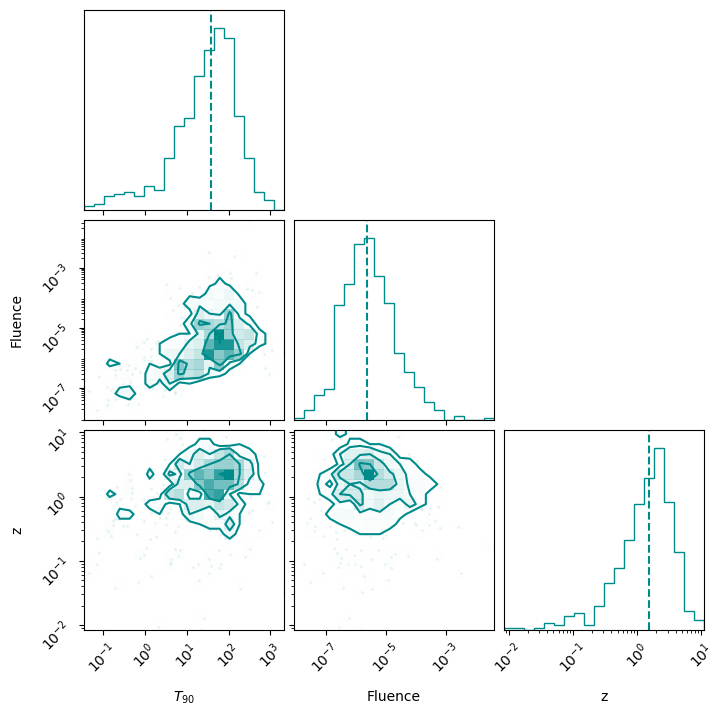

In [107]:
#Cornerplot of T90, fluence and redshift

corner_all = corner.corner(data_all, labels=["$T_{90}$", "Fluence", "z"], quantiles=[0.50], axes_scale=["log", "log", "log"], color="darkcyan")

## T90

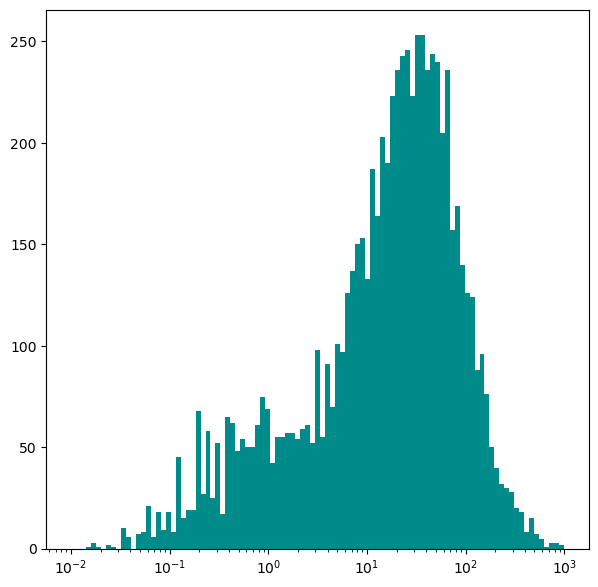

In [109]:
#Plot histogram
    
plt.figure()
plt.hist(T90, color="darkcyan", bins=np.logspace(-2, 3, 100))
plt.xscale("log")

Best KDE bandwidth = 0.1


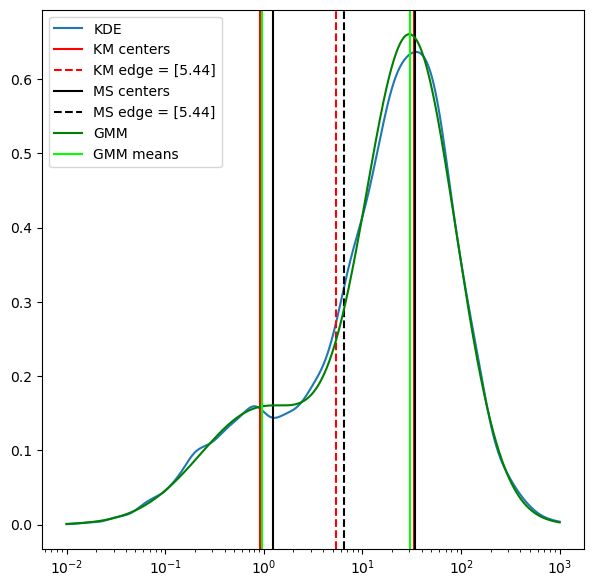

In [110]:
clusters = ComputeClusters(np.log10(T90), np.logspace(-2, 3, 1000))

## Fluence

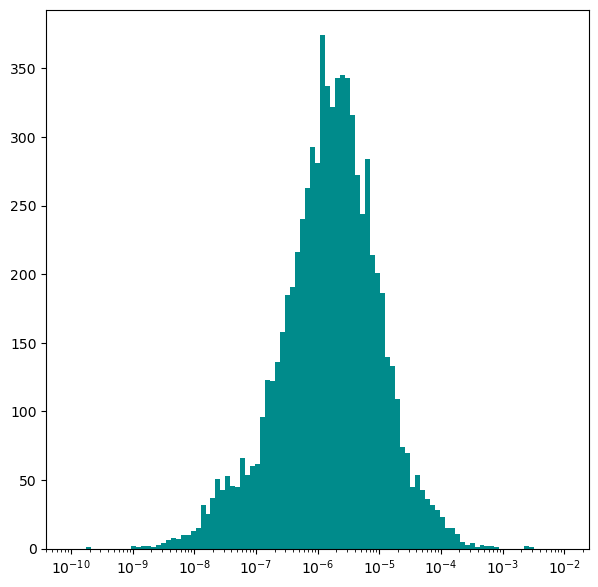

In [112]:
#Plot histogram
    
plt.figure()
plt.hist(fluence, color="darkcyan", bins=np.logspace(-10, -2, 100))
plt.xscale("log")

## Redshift

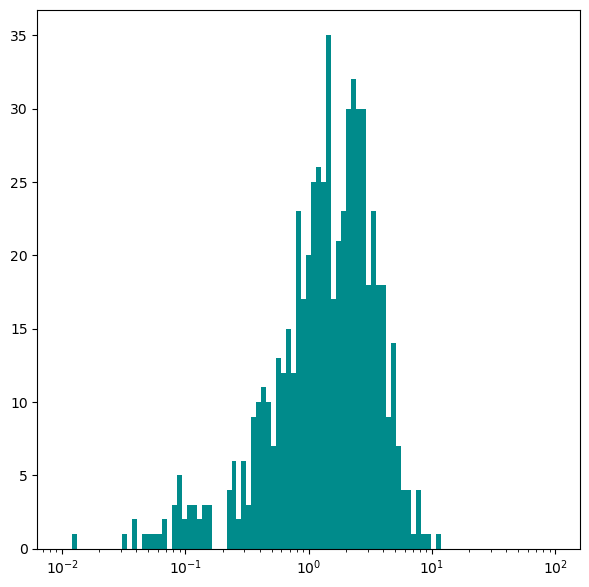

In [114]:
#Plot histogram
    
plt.figure()
plt.hist(z, color="darkcyan", bins=np.logspace(-2, 2, 100))
plt.xscale("log")

Best KDE bandwidth = 0.1


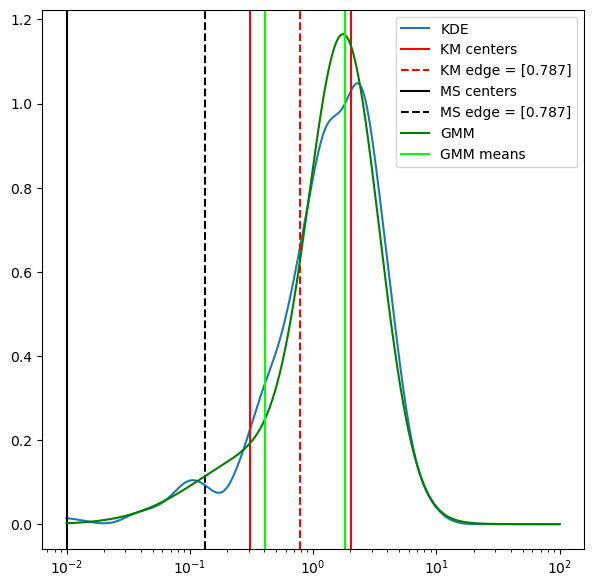

In [115]:
ComputeClusters(np.log10(z), np.logspace(-2, 2, 1000), ms_b=0.4)

The presence of two modes in the redshift distribution is way less evident than in $T_{90}$, so the clustering algorithms can only find one of the peaks.

## GMM with measurement errors

Since the $T_{90}$ measurements have uncertainties i try to fit a GMM considering the heteroscedastic errors.

In [165]:
#GMM model with measurement uncertainties
def GMMErrors(params, x, x_err):
    a, mu_1, mu_2, sigma_1, sigma_2 = params
    
    e_1 = np.sqrt(sigma_1**2 + x_err**2)
    e_2 = np.sqrt(sigma_2**2 + x_err**2)
    
    return a * norm(mu_1, e_1).pdf(x) + (1 - a) * norm(mu_2, e_2).pdf(x)


def logLikelihood(params, x, x_err):
    return np.sum(np.log(GMMErrors(params, x, x_err)))


def logPrior(params):
    a, mu_1, mu_2, sigma_1, sigma_2 = params

    if (0 < a < 1) and (1e-2 < mu_1 < 1e3) and (1e-2 < mu_2 < 1e3) and (0 < sigma_1 < 200) and (0 < sigma_2 < 200):
        return -np.log(sigma_1) - np.log(sigma_2)
    
    else:
        return -np.inf


def logPosterior(params, x, x_err):
    prior = logPrior(params)
    # print("L = ", logLikelihood(params, x, x_err))

    if prior == -np.inf:
        return -np.inf

    else:
        return prior + logLikelihood(params, x, x_err)
    

In [181]:
#Use MCMC

n_walkers = 20
n_dim = 5
n_steps = 40000

start_point = np.random.random((n_walkers, n_dim)) + [0.5, 0.9, 1, 0, 2]

sampler = emcee.EnsembleSampler(n_walkers, n_dim, logPosterior, args=[np.log10(T90), T90_err / (T90 * np.log(10))], threads=-1)
sampler.run_mcmc(start_point, n_steps, progress=True)

  0%|                                                                                        | 0/40000 [00:00<?, ?it/s]D:\anaconda3\envs\astroML\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [24:32<00:00, 27.16it/s]


State([[0.74515556 1.46960729 0.12033369 0.43182121 0.5703745 ]
 [0.76140925 1.44993601 0.05723478 0.4386505  0.58809628]
 [0.75444372 1.466558   0.04651406 0.44286205 0.54585256]
 [1.40287535 1.15561619 1.30338884 0.76258589 2.52726009]
 [0.77724378 1.43988863 0.01928353 0.45271863 0.56960956]
 [0.99945766 1.11854179 3.05377784 0.74549471 5.62765796]
 [0.77087048 1.45521967 0.01017002 0.44222805 0.54303987]
 [0.75857152 1.46870099 0.07355764 0.4451432  0.60291989]
 [0.76372965 1.46250863 0.06128721 0.43597419 0.5866831 ]
 [0.99996205 1.14337222 2.34782838 0.7410864  4.29939857]
 [0.76615806 1.45763249 0.03178144 0.44731456 0.58901813]
 [0.76736544 1.47111128 0.05751476 0.43654792 0.58212245]
 [0.77546884 1.45887386 0.05680777 0.44483047 0.56873627]
 [0.76247567 1.45992029 0.12095468 0.4403385  0.58032256]
 [0.75250642 1.47239792 0.13572199 0.43816827 0.61696998]
 [0.75257427 1.46179537 0.04469415 0.43755779 0.60289526]
 [0.75253685 1.47762626 0.09180716 0.43206973 0.6006171 ]
 [0.7693

Acceptance fraction for each walker = [0.442525 0.437    0.4461   0.       0.44005  0.027975 0.438775 0.441675
 0.44315  0.028725 0.438875 0.4343   0.442775 0.4365   0.44315  0.44025
 0.440275 0.441025 0.436925 0.44615 ]


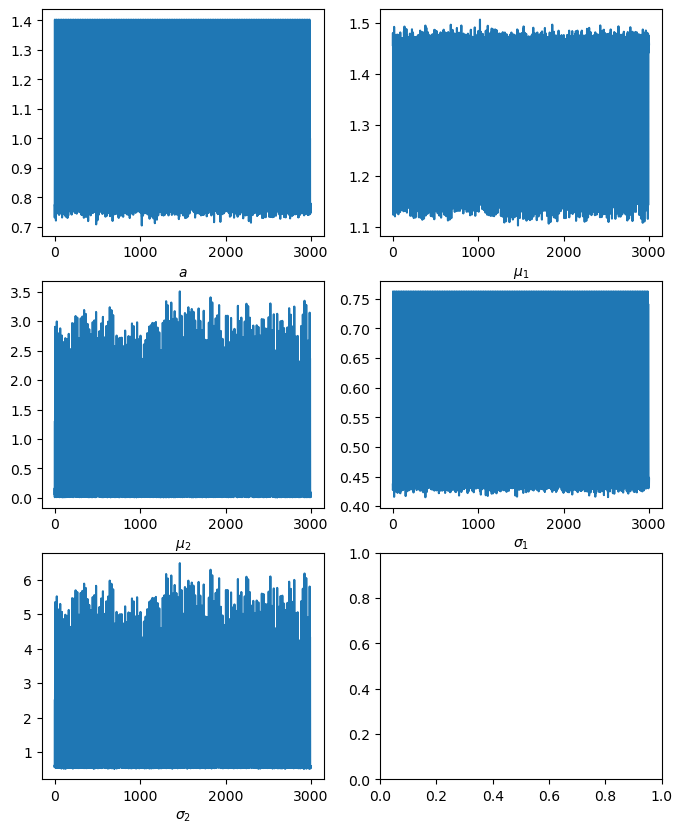

In [230]:
#Burn in and thinning

burn = 2000
thin = int(max(sampler.get_autocorr_time(quiet=True)))
trace = sampler.get_chain(discard=burn, thin=thin, flat=True)

acc_fraction = sampler.acceptance_fraction
print("Acceptance fraction for each walker = " + str(acc_fraction))

#Traceplot

x_grid = np.arange(0, trace.shape[0])

fig, ax = plt.subplots(3, 2, figsize=(8, 10))
par_names = ["$a$", "$\\mu_1$", "$\\mu_2$", "$\sigma_1$", "$\sigma_2$"]
par_count = 0

for i in range(0, 3):
    for j in range(0, 2):
        if i != 2 or (i == 2 and j == 0):
            ax[i, j].plot(x_grid, trace[:, par_count])
            ax[i, j].set_xlabel(par_names[par_count])
            par_count += 1

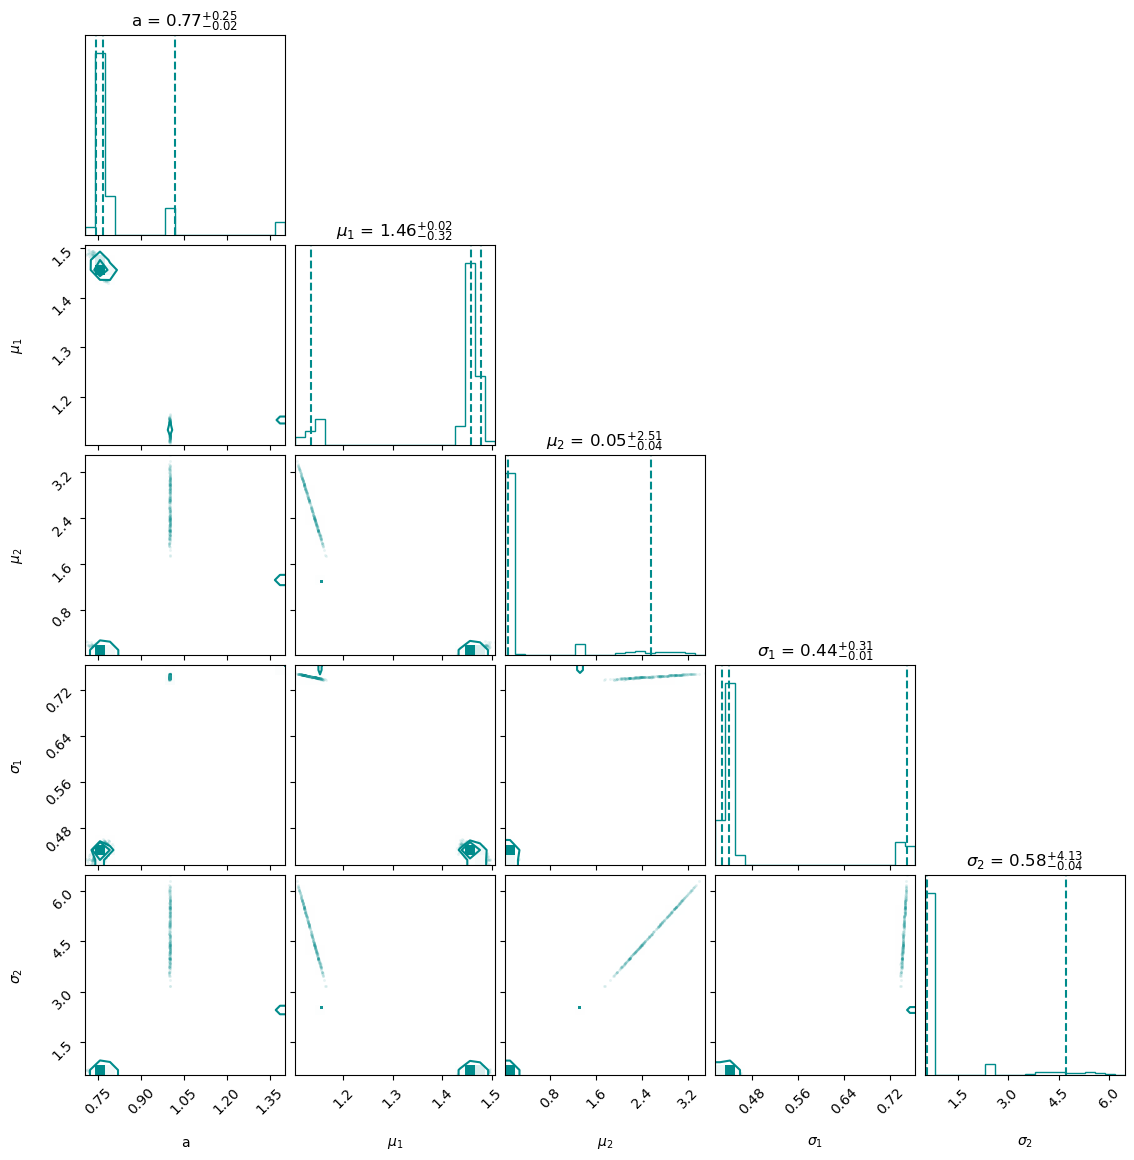

In [232]:
fig_corner = corner.corner(trace, labels=["a", "$\\mu_1$", "$\\mu_2$", "$\sigma_1$", "$\sigma_2$"], show_titles=True, levels=[0.39, 0.68, 0.90], quantiles=[0.05, 0.50, 0.95], color="darkcyan")

Responsibilities:
Gaussian 1 (long GRBs): 0.7675445774352936
Gaussian 2 (short GRBs): 0.23245542256470642


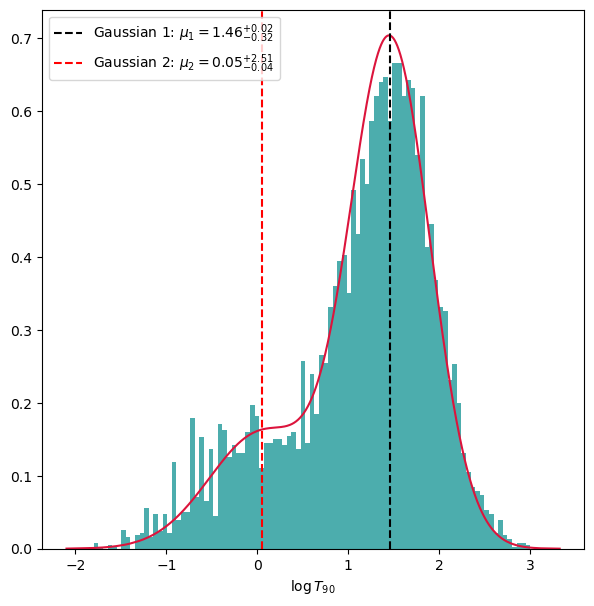

In [234]:
medians = np.median(trace, axis=0)
credible_95 = np.quantile(trace, 0.95, axis=0) - medians
credible_005 = medians - np.quantile(trace, 0.05, axis=0)
grid = np.linspace(0.01, 1000, 1000)

fig_gmm, ax_gmm = plt.subplots()
plt.hist(np.log10(T90), np.linspace(-2, 3, 100), color="darkcyan", alpha=0.7, density=True)
plt.plot(np.sort(np.log10(T90)), GMMErrors(medians, np.sort(np.log10(T90)), 0), color="crimson")
ax_gmm.axvline(medians[1], color="black", linestyle="--", label="Gaussian 1: $\\mu_1 = " + f"{medians[1]:.2f}" + 
    "^{+" + f"{credible_95[1]:.2f}" + "}_{-" + f"{credible_005[1]:.2f}" + "}$")
ax_gmm.axvline(medians[2], color="red", linestyle="--", label="Gaussian 2: $\\mu_2 = " + f"{medians[2]:.2f}" + 
    "^{+" + f"{credible_95[2]:.2f}" + "}_{-" + f"{credible_005[2]:.2f}" + "}$")
plt.xlabel("$\log{T_{90}}$")
plt.legend()

#Print gaussian responsibilities

print("Responsibilities:")

if medians[1] > medians[2]:
    print("Gaussian 1 (long GRBs): " + str(medians[0]))
    print("Gaussian 2 (short GRBs): " + str(1 - medians[0]))

else:
    print("Gaussian 1 (short GRBs): " + str(medians[0]))
    print("Gaussian 2 (long GRBs): " + str(1 - medians[0]))

## PCA

I tried using PCA to make clustering easier, using $T_{90}$, fluence and redshift.

In [192]:
#Scale the data first

scaler = StandardScaler()
scaler.fit(log_data_all)
data_s = scaler.transform(log_data_all)

In [193]:
pca = PCA(n_components=2)
pca.fit(data_s)
data_red = pca.transform(data_s)

Text(0, 0.5, 'Component 1')

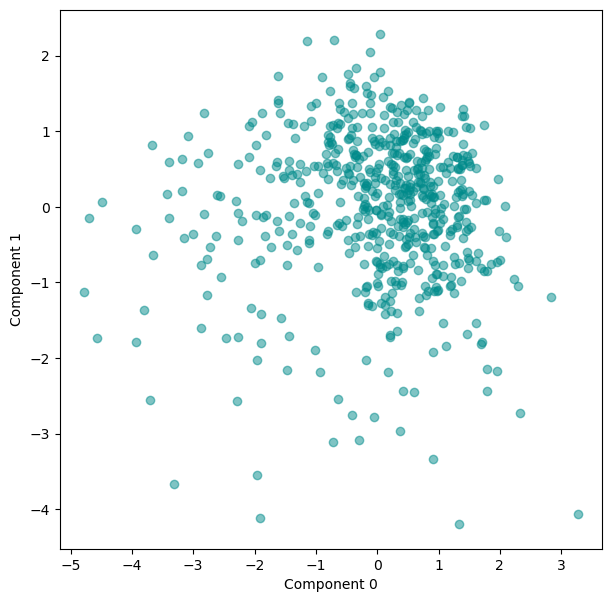

In [194]:
plt.figure()
plt.scatter(data_red[:, 0], data_red[:, 1], color="darkcyan", alpha=0.5)
plt.xlabel("Component 0")
plt.ylabel("Component 1")

In [195]:
#Use KMeans clustering

km = KMeans(n_init="auto", n_clusters=2)
km.fit(data_red)

labels = km.predict(data_red)
km_centers = km.cluster_centers_

In [196]:
T90_miss_all = np.array(data["T90"], dtype=float)[missing_all]

names = []

#If the first cluster is at higher times than the first then it repersents LGRBs, otherwise it's the opposite

if np.mean(T90_miss_all[labels == 0]) > np.mean(T90_miss_all[labels == 1]):
    names = ["Long GRBs", "Short GRBs"]

else:
    names = ["Short GRBs", "Long GRBs"]

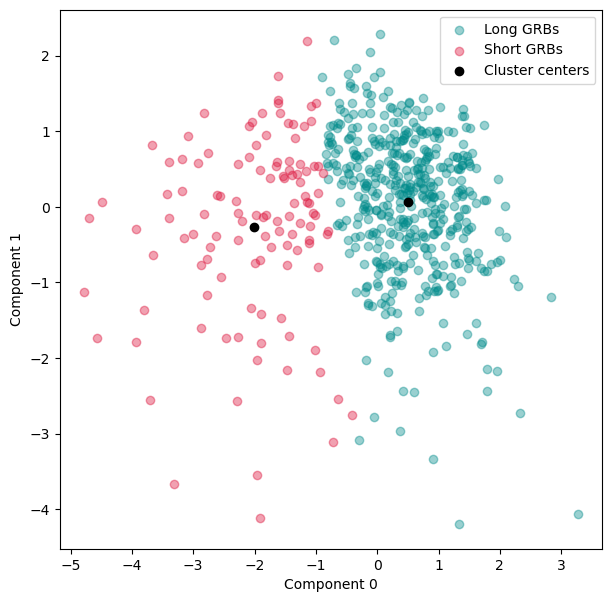

In [197]:
#PCA components plot with clustering

plt.figure()
plt.scatter(data_red[:, 0][labels == 0], data_red[:, 1][labels == 0], color="darkcyan", alpha=0.4, label=names[0])
plt.scatter(data_red[:, 0][labels == 1], data_red[:, 1][labels == 1], color="crimson", alpha=0.4, label=names[1])
plt.scatter(km_centers[:, 0], km_centers[:, 1], color="black", label="Cluster centers")
plt.xlabel("Component 0")
plt.ylabel("Component 1")
plt.legend()

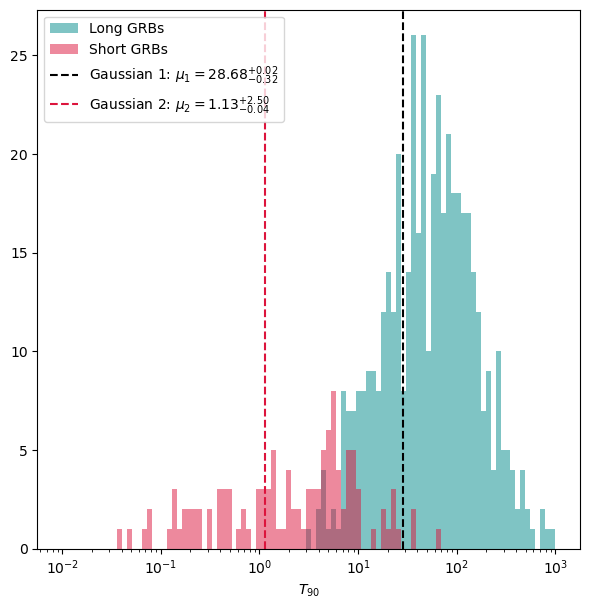

In [215]:
#Plot the T90 distribution with the clusters found by KMeans and the gaussians found by also considering the T90 errors

fig_pca = plt.figure()
ax_pca = fig_pca.add_subplot()
plt.hist(T90_miss_all[labels == 0], bins=np.logspace(-2, 3, 100), color="darkcyan", alpha=0.5, label=names[0])
plt.hist(T90_miss_all[labels == 1], bins=np.logspace(-2, 3, 100), color="crimson", alpha=0.5, label=names[1])
ax_pca.axvline(10**medians[1], color="black", linestyle="--", label="Gaussian 1: $\\mu_1 = " + f"{10**medians[1]:.2f}" + 
    "^{+" + f"{credible_95[1]:.2f}" + "}_{-" + f"{credible_005[1]:.2f}" + "}$")
ax_pca.axvline(10**medians[2], color="crimson", linestyle="--", label="Gaussian 2: $\\mu_2 = " + f"{10**medians[2]:.2f}" + 
    "^{+" + f"{credible_95[2]:.2f}" + "}_{-" + f"{credible_005[2]:.2f}" + "}$")
plt.xlabel("$T_{90}$")
plt.xscale("log")
plt.legend()

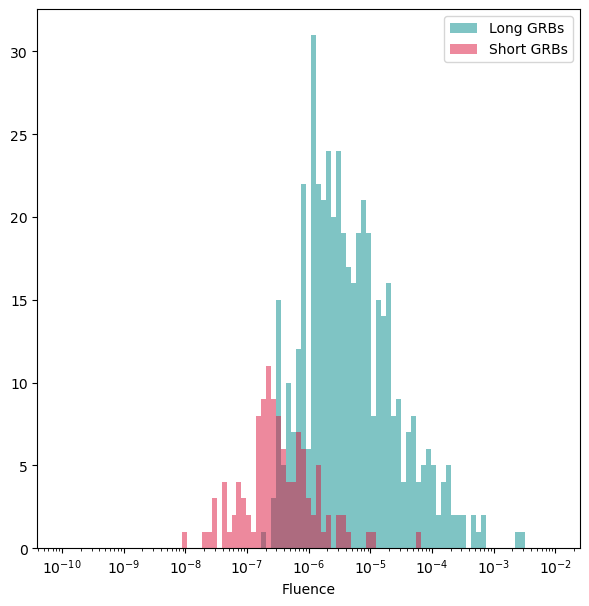

In [199]:
fluence_miss_all = np.array(data["fluence"], dtype=float)[missing_all]

plt.figure()
plt.hist(fluence_miss_all[labels == 0], bins=np.logspace(-10, -2, 100), color="darkcyan", alpha=0.5, label=names[0])
plt.hist(fluence_miss_all[labels == 1], bins=np.logspace(-10, -2, 100), color="crimson", alpha=0.5, label=names[1])
plt.xlabel("Fluence")
plt.xscale("log")
plt.legend()

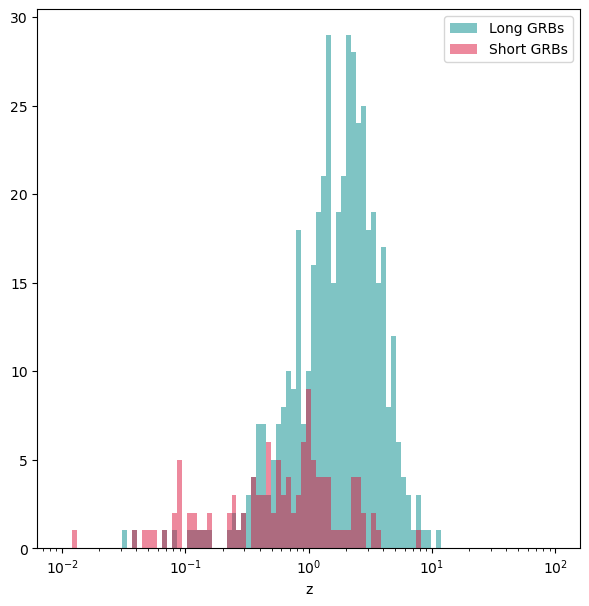

In [200]:
z_miss_all = np.array(data["redshift"], dtype=float)[missing_all]

plt.figure()
plt.hist(z_miss_all[labels == 0], bins=np.logspace(-2, 2, 100), color="darkcyan", alpha=0.5, label=names[0])
plt.hist(z_miss_all[labels == 1], bins=np.logspace(-2, 2, 100), color="crimson", alpha=0.5, label=names[1])
plt.xlabel("z")
plt.xscale("log")
plt.legend()

Long GRBs seem to be located at higher redshift than short GRBs.